In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Bidirectional

In [2]:
colnames = ['DateTime','Open', 'High', 'Low', 'Close', 'Volume', 'Extra']


In [3]:
df = pd.read_csv(
    'USDCHFM5.csv',
    encoding='utf-16',
    header=None,
    names=colnames
)

In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y.%m.%d %H:%M')
df.set_index('DateTime', inplace=True)

# Print bossku
print(df.head())
print(df.dtypes)

                        Open     High      Low    Close  Volume  Extra
DateTime                                                              
2022-07-12 09:15:00  0.98360  0.98430  0.98358  0.98407     473      0
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390     462      0
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412     454      0
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390     581      0
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423     540      0
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Extra       int64
dtype: object


In [5]:
ohlc = df[['Open','High','Low','Close']]
print(ohlc.head())

                        Open     High      Low    Close
DateTime                                               
2022-07-12 09:15:00  0.98360  0.98430  0.98358  0.98407
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
ohlc_scaled = scaler.fit_transform(ohlc)
print("Contoh hasil normalisasi:", ohlc_scaled[:3])

Contoh hasil normalisasi: [[0.80523968 0.80857609 0.80841416 0.8081925 ]
 [0.80825532 0.80838774 0.80847714 0.80712446]
 [0.80706163 0.80807383 0.80822522 0.80850663]]


In [7]:
def create_multistep_dataset(data, window_size=12, steps_ahead=5):
    X, y = [], []
    for i in range(len(data) - window_size - steps_ahead):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + steps_ahead])
    return np.array(X), np.array(y)

In [8]:
window_size = 12     
steps_ahead = 5      

In [9]:
X, y = create_multistep_dataset(ohlc_scaled, window_size, steps_ahead)
print("X shape:", X.shape) 
print("y shape:", y.shape)  

X shape: (99998, 12, 4)
y shape: (99998, 5, 4)


In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (79998, 12, 4)
y_train shape: (79998, 5, 4)
X_test shape : (20000, 12, 4)
y_test shape : (20000, 5, 4)


In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(window_size, 4)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(5 * 4))
model.add(Reshape((5, 4)))

d:\abel_prediksi\LSTM_MultiVariant_MultiStepPrediction\.venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,596 (221.08 KB)

 Trainable params: 56,596 (221.08 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=13,
    batch_size=64,
    validation_split=0.1,   
    verbose=1
)

Epoch 1/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0174 - mae: 0.0539 - val_loss: 2.9536e-04 - val_mae: 0.0130
Epoch 2/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.1691e-04 - mae: 0.0083 - val_loss: 1.3636e-04 - val_mae: 0.0081
Epoch 3/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 7.0682e-05 - mae: 0.0064 - val_loss: 1.2039e-04 - val_mae: 0.0083
Epoch 4/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.8907e-05 - mae: 0.0057 - val_loss: 1.5643e-04 - val_mae: 0.0099
Epoch 5/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.1088e-05 - mae: 0.0053 - val_loss: 1.4183e-04 - val_mae: 0.0089
Epoch 6/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 4.5180e-05 - mae: 0.0050 - val_loss: 1.3567e-04 - val_mae: 0.0087
Epoch 7/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 4.1451e-05 - mae: 0.0048 - val_loss: 1.8791e-04 - val_mae: 0.0111
Epoch 8/13
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 4.3666e-05 - mae: 0.0049 - val_loss: 

In [15]:
y_pred = model.predict(X_test)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [16]:

y_pred_flat = y_pred.reshape(-1, 4)
y_test_flat = y_test.reshape(-1, 4)


y_pred_inv = scaler.inverse_transform(y_pred_flat)
y_test_inv = scaler.inverse_transform(y_test_flat)


y_pred_inv = y_pred_inv.reshape(-1, 5, 4)
y_test_inv = y_test_inv.reshape(-1, 5, 4)


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature_names = ['Open', 'High', 'Low', 'Close']

for i, name in enumerate(feature_names):
    mae = mean_absolute_error(y_test_inv[:, :, i], y_pred_inv[:, :, i])
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, :, i], y_pred_inv[:, :, i]))
    print(f"{name} — MAE: {mae:.6f}, RMSE: {rmse:.6f}")


Open — MAE: 0.000477, RMSE: 0.000637
High — MAE: 0.000486, RMSE: 0.000640
Low — MAE: 0.000550, RMSE: 0.000743
Close — MAE: 0.000534, RMSE: 0.000705


In [18]:
for t in range(5):
    close_mae = mean_absolute_error(y_test_inv[:, t, 3], y_pred_inv[:, t, 3])
    print(f"Close — Timestep t+{t+1}: MAE = {close_mae:.6f}")


Close — Timestep t+1: MAE = 0.000458
Close — Timestep t+2: MAE = 0.000466
Close — Timestep t+3: MAE = 0.000546
Close — Timestep t+4: MAE = 0.000610
Close — Timestep t+5: MAE = 0.000589


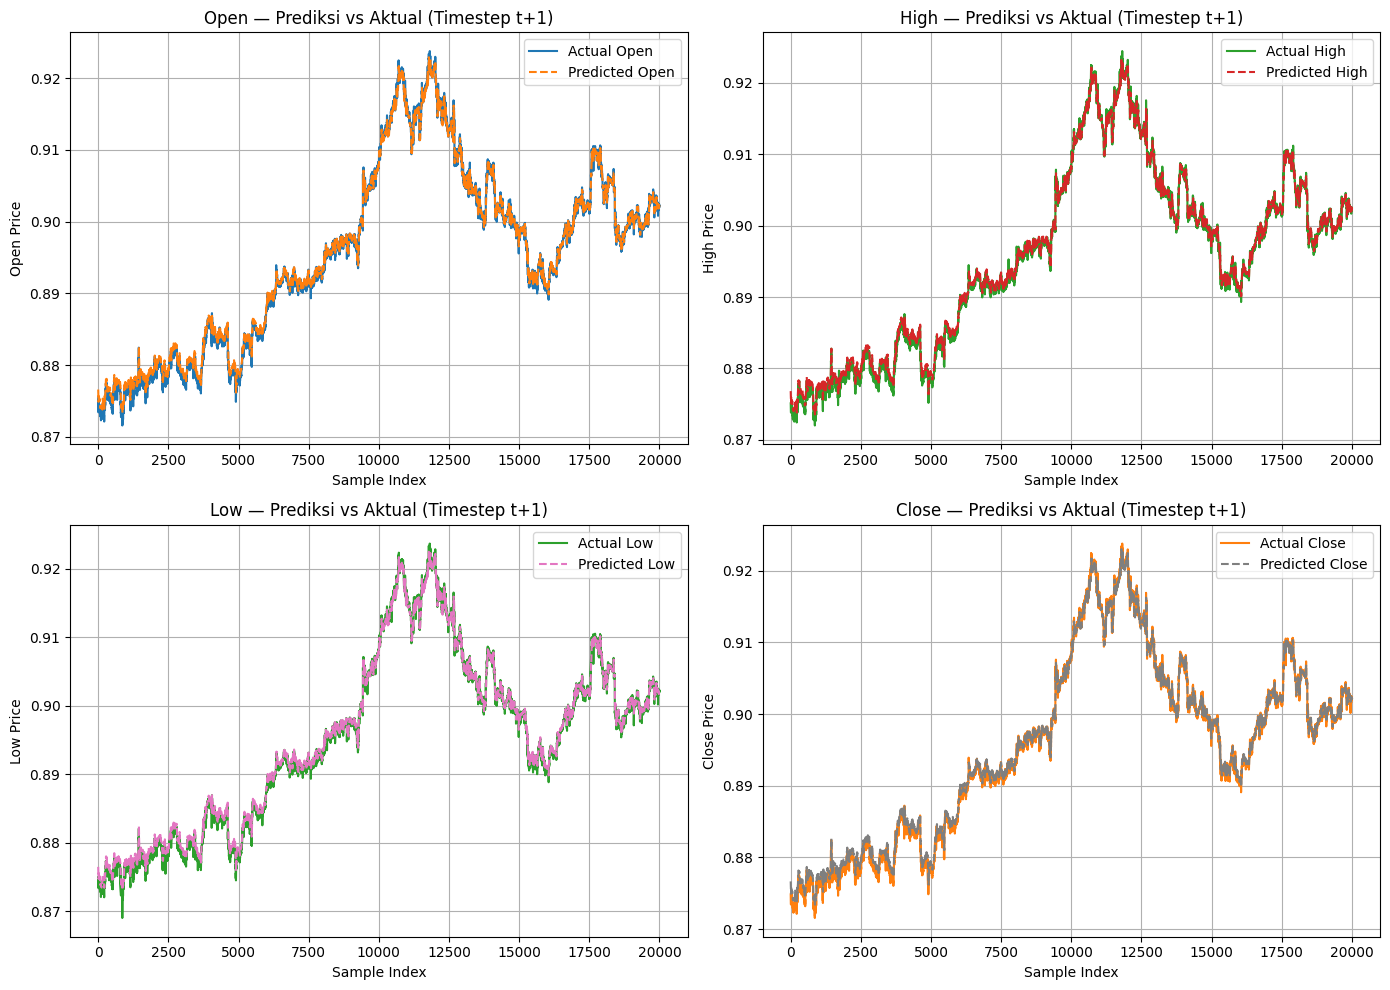

In [19]:
# tanyain pak surya bel bener apa salahnya

feature_names = ['Open', 'High', 'Low', 'Close']
actual_colors = ['tab:blue', 'tab:green', 'tab:green', 'tab:orange']  
predicted_colors = ['tab:orange', 'tab:red', 'tab:pink', 'tab:gray']  

plt.figure(figsize=(14, 10))

for i, name in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_inv[:, 0, i], label=f'Actual {name}', color=actual_colors[i])
    plt.plot(y_pred_inv[:, 0, i], label=f'Predicted {name}', linestyle='--', color=predicted_colors[i])
    plt.title(f'{name} — Prediksi vs Aktual (Timestep t+1)')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{name} Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


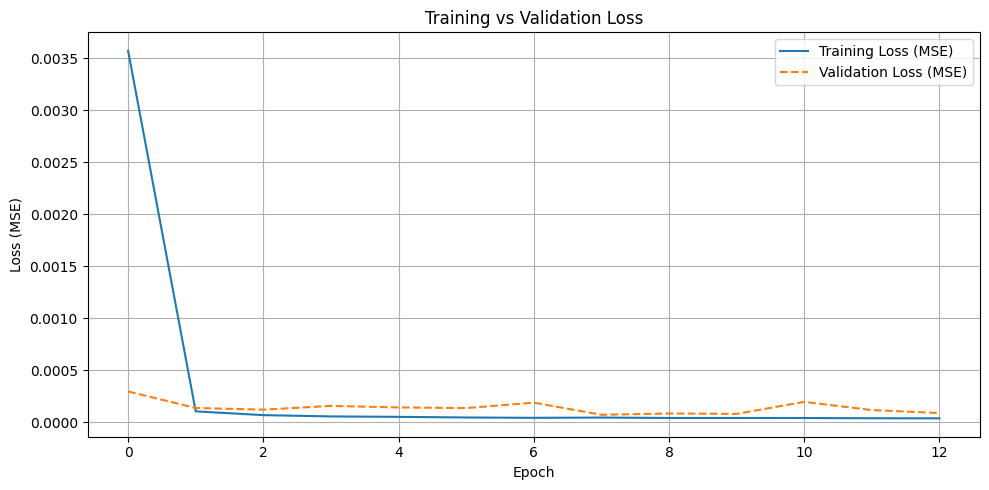

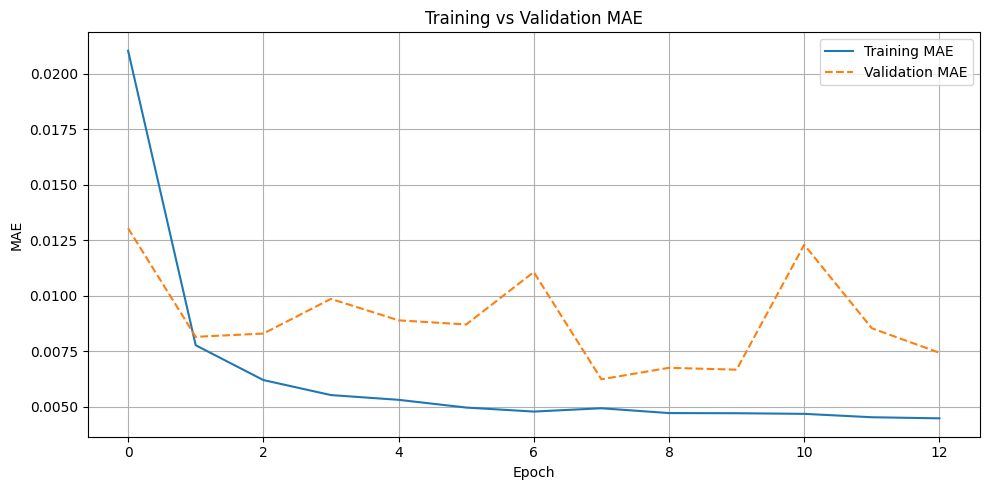

In [20]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

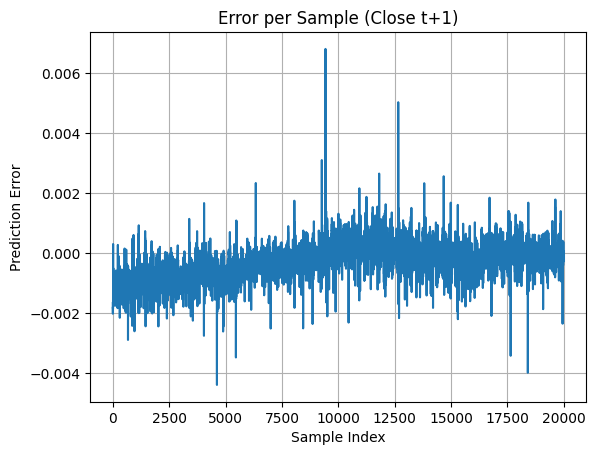

In [21]:
error = y_test_inv[:, 0, 3] - y_pred_inv[:, 0, 3]
plt.plot(error)
plt.title("Error per Sample (Close t+1)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()



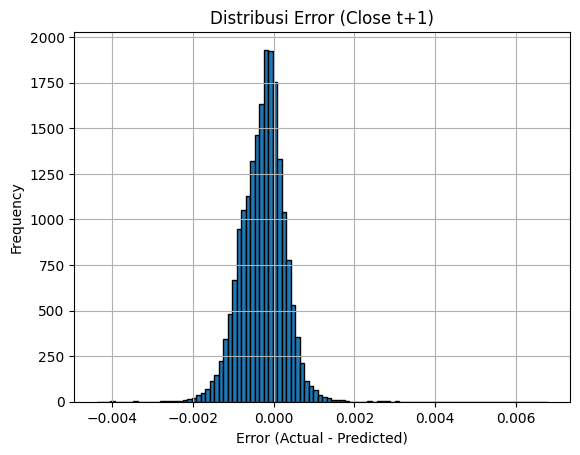

In [22]:
plt.hist(error, bins=100, edgecolor='black')
plt.title("Distribusi Error (Close t+1)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [23]:
# Mclarenlu warna apa bos?
model.save('lstm_multivariate_forex_12Timestep13EPOCH64BATCH_architecturenum2.h5')